2.8.0
255 0 21.067888888888888


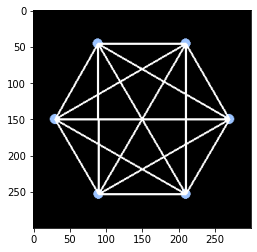

In [11]:
import random
import time
import importlib
import game
importlib.reload(game)
from game import ColorableCliqueGame
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print(tf.__version__)

colors = [(255,100,100), (100,100,255)]
env = ColorableCliqueGame(300,300,6,colors)


imgdata = env.frame()
plt.imshow(imgdata)
print(np.max(imgdata), np.min(imgdata), np.average(imgdata))
plt.show()
#env.close()

In [ ]:
def draw():
    imgdata = env.frame()
    plt.imshow(imgdata)
    print(np.max(imgdata), np.min(imgdata), np.average(imgdata))
    plt.show()

In [16]:
moves = env.getMoves()
rm = moves[int(random.random() * len(moves))]
env.applyMove(rm)
env.frame

(1, 5)
